# Vision Safari Dataset 점검 & 업로드

JSONL + 이미지를 로드하여 DataFrame으로 확인하고,
HuggingFace / Gemini fine-tuning 형식으로 업로드합니다.

### dataset.jsonl 스키마 (DataCollector 기준)
| 필드 | 설명 |
|---|---|
| `episode_id` | 에피소드 UUID (8자) |
| `mission` | 미션 텍스트 |
| `turn` | 턴 번호 (0-based) |
| `system_prompt` | 시스템 프롬프트 전문 |
| `context_text` | 턴별 컨텍스트 (위치, 메모장 등) |
| `image_file` | 스크린샷 상대 경로 (`images/ep_xxx_turn_000.png`) |
| `tool_calls` | `[{name, args}]` — 에이전트가 호출한 도구들 |
| `tool_results` | `[{name, result}]` — 도구 실행 결과 |
| `raw_request` | Gemini API 원본 요청 (systemInstruction, contents, tools, ...) |
| `raw_response` | Gemini API 원본 응답 (candidates, usageMetadata, ...) |

In [1]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display
from dotenv import load_dotenv

load_dotenv()
DATA_DIR = Path("../data/safari-dataset")
DATASET_FILE = DATA_DIR / "dataset.jsonl"

# Load JSONL
rows = []
with open(DATASET_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

print(f"Loaded {len(rows)} turns from {DATASET_FILE}")
print(f"Episodes: {len(set(r['episode_id'] for r in rows))}")
print(f"Fields: {list(rows[0].keys()) if rows else '(empty)'}")

Loaded 13 turns from ..\data\safari-dataset\dataset.jsonl
Episodes: 7
Fields: ['episode_id', 'mission', 'turn', 'system_prompt', 'context_text', 'image_file', 'tool_calls', 'tool_results', 'thought_text', 'raw_request', 'raw_response']


In [2]:
# DataFrame으로 전체 데이터 확인
df = pd.DataFrame([
    {
        "episode_id": r["episode_id"],
        "mission": r["mission"][:40] + "..." if len(r["mission"]) > 40 else r["mission"],
        "turn": r["turn"],
        "context_preview": r["context_text"][:60] + "..." if len(r["context_text"]) > 60 else r["context_text"],
        "image_file": r["image_file"],
        "image_exists": (DATA_DIR / r["image_file"]).exists(),
        "tool_calls": ", ".join(c["name"] for c in r.get("tool_calls", [])),
        "tool_results_count": len(r.get("tool_results", [])),
        "has_raw_request": r.get("raw_request") is not None,
        "has_raw_response": r.get("raw_response") is not None,
    }
    for r in rows
])

print(f"Shape: {df.shape}")
display(df)

# 에피소드별 요약
episode_summary = df.groupby("episode_id").agg(
    mission=("mission", "first"),
    turns=("turn", "count"),
    max_turn=("turn", "max"),
    images_ok=("image_exists", "sum"),
    has_raw=("has_raw_request", "sum"),
).reset_index()
print("\n에피소드별 요약:")
episode_summary

Shape: (13, 10)


,episode_id,mission,turn,context_preview,image_file,image_exists,tool_calls,tool_results_count,has_raw_request,has_raw_response
0,09b8ac2c,파란색 기린을 잡아줘,0,Mission: 파란색 기린을 잡아줘\nStep: 1/180\nPosition: (...,images/ep_09b8ac2c_turn_000.png,True,"update_notepad, move, catch, declare_found",4,True,True
1,09b8ac2c,파란색 기린을 잡아줘,1,Mission: 파란색 기린을 잡아줘\nStep: 2/180\nPosition: (...,images/ep_09b8ac2c_turn_001.png,True,"update_notepad, declare_done",2,True,True
2,daa10ef3,파란색 돼지를 잡아줘,0,Mission: 파란색 돼지를 잡아줘\nStep: 1/180\nPosition: (...,images/ep_daa10ef3_turn_000.png,True,"update_notepad, move, catch, declare_found, de...",5,True,True
3,cdd35e78,노란색 배경 코끼리를 잡아줘,0,Mission: 노란색 배경 코끼리를 잡아줘\nStep: 1/180\nPositio...,images/ep_cdd35e78_turn_000.png,True,"update_notepad, move, catch, declare_found",4,True,True
4,cdd35e78,노란색 배경 코끼리를 잡아줘,1,Mission: 노란색 배경 코끼리를 잡아줘\nStep: 2/180\nPositio...,images/ep_cdd35e78_turn_001.png,True,"move, catch, update_notepad, declare_found, de...",5,True,True
5,b3f97d07,빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래,0,Mission: 빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래\nSt...,images/ep_b3f97d07_turn_000.png,True,"update_notepad, move",2,True,True
6,b3f97d07,빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래,1,Mission: 빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래\nSt...,images/ep_b3f97d07_turn_001.png,True,"move, catch, update_notepad",3,True,True
7,b3f97d07,빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래,2,Mission: 빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래\nSt...,images/ep_b3f97d07_turn_002.png,True,"move, catch, declare_found, update_notepad",4,True,True
8,b3f97d07,빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래,3,Mission: 빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래\nSt...,images/ep_b3f97d07_turn_003.png,True,"move, catch, update_notepad, declare_found, de...",5,True,True
9,0f1e0a49,보라색 원숭이를 잡아줘,0,Mission: 보라색 원숭이를 잡아줘\nStep: 1/180\nPosition: ...,images/ep_0f1e0a49_turn_000.png,True,"update_notepad, move, catch, declare_found, de...",5,True,True



에피소드별 요약:


,episode_id,mission,turns,max_turn,images_ok,has_raw
0,09b8ac2c,파란색 기린을 잡아줘,2,1,2,2
1,0f1e0a49,보라색 원숭이를 잡아줘,1,0,1,1
2,5398c86a,노라색 배경 기린을 잡아줘,1,0,1,1
3,b3f97d07,빨간색 배경 사자를 잡은 후에 보라색 배경 얼룩말을 잡아줄래,4,3,4,4
4,cdd35e78,노란색 배경 코끼리를 잡아줘,2,1,2,2
5,daa10ef3,파란색 돼지를 잡아줘,1,0,1,1
6,efebcd49,연두색 배경 돼지를 잡아줘,2,1,2,2


Episode: 09b8ac2c
Mission: 파란색 기린을 잡아줘
Turn: 0
Image: images/ep_09b8ac2c_turn_000.png

--- Context Text ---
Mission: 파란색 기린을 잡아줘
Step: 1/180
Position: (25, 25)

Found Targets: (none)

Notepad:
(empty)

--- Tool Calls (4) ---
  update_notepad({"content": "[맵] 5x5 격자 (각 칸=10x10 구역, V=탐색완료, .=미탐색)\n.....\n.....\n..V..\n.....\n.....\n[목격] 🦒@(29)
  move({"actions": [{"direction": "RIGHT", "steps": 3}, {"direction": "DOWN", "steps": 3}]})
  catch({"direction": "RIGHT"})
  declare_found({"target": "파란색 기린"})

--- Tool Results (4) ---
  update_notepad → {"status": "updated"}
  move → {"moved": true, "actualSteps": 3, "blocked": false, "pos": {"x": 28, "y": 28}}
  catch → {"success": true, "animal": {"emoji": "🦒", "bgColor": "#0000FF"}, "position": {"x": 29, "y": 28}}
  declare_found → {"status": "found", "target": "파란색 기린", "total": 1}

--- Raw Payload ---
  raw_request: ✅
  raw_response: ✅


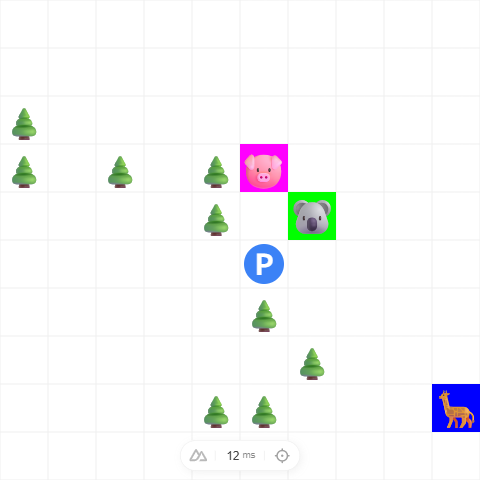

In [3]:
# 첫 번째 엔트리 상세 확인
if rows:
    r = rows[0]
    print(f"Episode: {r['episode_id']}")
    print(f"Mission: {r['mission']}")
    print(f"Turn: {r['turn']}")
    print(f"Image: {r['image_file']}")
    print(f"\n--- Context Text ---")
    print(r["context_text"])
    print(f"\n--- Tool Calls ({len(r.get('tool_calls', []))}) ---")
    for tc in r.get("tool_calls", []):
        print(f"  {tc['name']}({json.dumps(tc['args'], ensure_ascii=False)[:100]})")
    print(f"\n--- Tool Results ({len(r.get('tool_results', []))}) ---")
    for tr in r.get("tool_results", []):
        print(f"  {tr['name']} → {json.dumps(tr['result'], ensure_ascii=False)[:100]}")
    print(f"\n--- Raw Payload ---")
    print(f"  raw_request: {'✅' if r.get('raw_request') else '❌ (legacy)'}")
    print(f"  raw_response: {'✅' if r.get('raw_response') else '❌ (legacy)'}")

    # 이미지 미리보기
    from PIL import Image as PILImage
    img_path = DATA_DIR / r["image_file"]
    if img_path.exists():
        display(PILImage.open(img_path))

## Gemini Fine-Tuning 포맷 변환

각 턴을 Gemini API 네이티브 형식으로 변환합니다.

```
1턴 = systemInstruction + contents[0] user(text+image) + contents[1] model(functionCall) + contents[2] user(functionResponse) + tools
```

In [4]:
import base64

# Tool declarations (Gemini native format) — tools.ts 기준
TOOL_DECLARATIONS = [{
    "functionDeclarations": [
        {
            "name": "move",
            "description": "플레이어를 이동시킨다. 최대 4개 행동을 순서대로 실행하며, 각 행동은 방향(UP/DOWN/LEFT/RIGHT)과 칸수(1~3)를 가진다. 나무와 동물 모두 이동을 막으며, 중간에 막히면 거기서 중단된다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {
                    "actions": {
                        "type": "ARRAY",
                        "items": {
                            "type": "OBJECT",
                            "properties": {
                                "direction": {"type": "STRING", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]},
                                "steps": {"type": "INTEGER"}
                            },
                            "required": ["direction", "steps"]
                        }
                    }
                },
                "required": ["actions"]
            }
        },
        {
            "name": "update_notepad",
            "description": "메모장 전체를 덮어쓴다. 유지할 내용도 포함해서 작성해야 한다. 최대 2000자.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"content": {"type": "STRING"}},
                "required": ["content"]
            }
        },
        {
            "name": "catch",
            "description": "인접 타일(상하좌우)의 동물을 포획한다. 동물이 있는 방향을 지정하면 해당 동물을 잡아서 맵에서 제거한다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {
                    "direction": {"type": "STRING", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]}
                },
                "required": ["direction"]
            }
        },
        {
            "name": "declare_found",
            "description": "특정 타겟을 찾아서 도달했음을 선언한다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"target": {"type": "STRING"}},
                "required": ["target"]
            }
        },
        {
            "name": "declare_done",
            "description": "전체 미션이 완료되었음을 선언한다.",
            "parameters": {
                "type": "OBJECT",
                "properties": {"reason": {"type": "STRING"}},
                "required": []
            }
        }
    ]
}]


def convert_single_turn(entry, data_dir):
    """단일 턴을 Gemini fine-tuning 포맷으로 변환"""

    # --- raw_request가 있는 경우: 거의 그대로 사용 ---
    if entry.get("raw_request"):
        req = entry["raw_request"]
        res = entry.get("raw_response", {})

        contents = list(req.get("contents", []))

        # Model turn (from response)
        candidates = res.get("raw", {}).get("candidates", [])
        if candidates and candidates[0].get("content"):
            contents.append(candidates[0]["content"])

        # Function response turn
        if entry.get("tool_results"):
            contents.append({
                "role": "user",
                "parts": [
                    {"functionResponse": {"name": tr["name"], "response": tr["result"]}}
                    for tr in entry["tool_results"]
                ]
            })

        return {
            "systemInstruction": req.get("systemInstruction"),
            "contents": contents,
            "tools": req.get("tools", TOOL_DECLARATIONS),
        }

    # --- legacy 데이터: 수동 변환 ---
    # User turn
    user_parts = [{"text": entry["context_text"]}]
    img_path = data_dir / entry["image_file"]
    if img_path.exists():
        img_b64 = base64.b64encode(img_path.read_bytes()).decode()
        user_parts.append({"inlineData": {"mimeType": "image/png", "data": img_b64}})

    contents = [{"role": "user", "parts": user_parts}]

    # Model turn (functionCalls)
    if entry.get("tool_calls"):
        contents.append({
            "role": "model",
            "parts": [
                {"functionCall": {"name": tc["name"], "args": tc["args"]}}
                for tc in entry["tool_calls"]
            ]
        })

    # Function response turn
    if entry.get("tool_results"):
        contents.append({
            "role": "user",
            "parts": [
                {"functionResponse": {"name": tr["name"], "response": tr["result"]}}
                for tr in entry["tool_results"]
            ]
        })

    return {
        "systemInstruction": {"role": "user", "parts": [{"text": entry["system_prompt"]}]},
        "contents": contents,
        "tools": TOOL_DECLARATIONS,
    }


# 변환 실행
gemini_examples = [convert_single_turn(r, DATA_DIR) for r in rows]
print(f"Converted {len(gemini_examples)} examples")

# 변환 결과 검증
for i, ex in enumerate(gemini_examples):
    n_contents = len(ex.get("contents", []))
    has_sys = ex.get("systemInstruction") is not None
    has_tools = len(ex.get("tools", [])) > 0
    roles = [c.get("role", "?") for c in ex.get("contents", [])]
    print(f"  [{i}] systemInstruction={'✅' if has_sys else '❌'} | contents={n_contents} {roles} | tools={'✅' if has_tools else '❌'}")

Converted 13 examples
  [0] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [1] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [2] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [3] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [4] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [5] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [6] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [7] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [8] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [9] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [10] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [11] systemInstruction=❌ | contents=1 ['user'] | tools=✅
  [12] systemInstruction=❌ | contents=1 ['user'] | tools=✅


In [5]:
# 변환된 첫 번째 example 구조 미리보기 (base64 이미지는 축약)
if gemini_examples:
    ex = gemini_examples[0]

    def truncate_base64(obj):
        """base64 data를 축약해서 보기 편하게"""
        if isinstance(obj, dict):
            result = {}
            for k, v in obj.items():
                if k == "data" and isinstance(v, str) and len(v) > 100:
                    result[k] = f"<base64 {len(v)} chars>"
                else:
                    result[k] = truncate_base64(v)
            return result
        elif isinstance(obj, list):
            return [truncate_base64(item) for item in obj]
        return obj

    preview = truncate_base64(ex)
    print(json.dumps(preview, indent=2, ensure_ascii=False))

{
  "systemInstruction": null,
  "contents": [
    {
      "role": "user",
      "parts": [
        {
          "functionResponse": {
            "name": "update_notepad",
            "response": {
              "status": "updated"
            }
          }
        },
        {
          "functionResponse": {
            "name": "move",
            "response": {
              "moved": true,
              "actualSteps": 3,
              "blocked": false,
              "pos": {
                "x": 28,
                "y": 28
              }
            }
          }
        },
        {
          "functionResponse": {
            "name": "catch",
            "response": {
              "success": true,
              "animal": {
                "emoji": "🦒",
                "bgColor": "#0000FF"
              },
              "position": {
                "x": 29,
                "y": 28
              }
            }
          }
        },
        {
          "functionResponse": {
       

## Gemini Fine-Tuning JSONL 저장

In [ ]:
# dataset-gemini.jsonl 저장
GEMINI_FILE = DATA_DIR / "dataset-gemini.jsonl"

with open(GEMINI_FILE, "w", encoding="utf-8") as f:
    for ex in gemini_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

file_size_mb = GEMINI_FILE.stat().st_size / (1024 * 1024)
print(f"Saved {len(gemini_examples)} examples to {GEMINI_FILE}")
print(f"File size: {file_size_mb:.2f} MB")

## Qwen3-VL Fine-Tuning 포맷 변환

Gemini의 raw_response에서 **thought 파트**를 추출하여 Qwen3-VL의 assistant content로 매핑합니다.

### 매핑 구조
| Gemini | Qwen3-VL |
|---|---|
| `systemInstruction` | `{"role": "system", "content": ...}` |
| `contents[0]` (user + image) | `{"role": "user", "content": [image, text]}` |
| `thought` 파트 (candidates) | assistant `content` (사고 과정) |
| `functionCall` 파트 (candidates) | assistant `tool_calls` |
| `functionResponse` | `{"role": "tool", ...}` |
| Gemini `functionDeclarations` | OpenAI-style `tools` |



In [ ]:
# Qwen3-VL tool definitions (OpenAI format) — Gemini functionDeclarations에서 변환
QWEN3_TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "move",
            "description": "플레이어를 이동시킨다. 최대 4개 행동을 순서대로 실행하며, 각 행동은 방향(UP/DOWN/LEFT/RIGHT)과 칸수(1~3)를 가진다. 나무와 동물 모두 이동을 막으며, 중간에 막히면 거기서 중단된다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "actions": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "direction": {"type": "string", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]},
                                "steps": {"type": "integer"}
                            },
                            "required": ["direction", "steps"]
                        }
                    }
                },
                "required": ["actions"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "update_notepad",
            "description": "메모장 전체를 덮어쓴다. 유지할 내용도 포함해서 작성해야 한다. 최대 2000자.",
            "parameters": {
                "type": "object",
                "properties": {"content": {"type": "string"}},
                "required": ["content"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "catch",
            "description": "인접 타일(상하좌우)의 동물을 포획한다. 동물이 있는 방향을 지정하면 해당 동물을 잡아서 맵에서 제거한다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "direction": {"type": "string", "enum": ["UP", "DOWN", "LEFT", "RIGHT"]}
                },
                "required": ["direction"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "declare_found",
            "description": "특정 타겟을 찾아서 도달했음을 선언한다.",
            "parameters": {
                "type": "object",
                "properties": {"target": {"type": "string"}},
                "required": ["target"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "declare_done",
            "description": "전체 미션이 완료되었음을 선언한다.",
            "parameters": {
                "type": "object",
                "properties": {"reason": {"type": "string"}},
                "required": []
            }
        }
    }
]


def extract_thought(raw_response):
    """raw_response에서 Gemini thought 파트 추출"""
    if not raw_response:
        return None
    parts = raw_response.get("raw", {}).get("candidates", [{}])[0].get("content", {}).get("parts", [])
    thoughts = [p["text"] for p in parts if p.get("thought") == True]
    return "\n".join(thoughts) if thoughts else None


def convert_to_qwen3(entry):
    """단일 턴을 Qwen3-VL fine-tuning 포맷으로 변환"""
    thought = extract_thought(entry.get("raw_response"))
    if not thought:
        thought = entry.get("thought_text")  # fallback

    # System message
    messages = [
        {"role": "system", "content": entry["system_prompt"]},
    ]

    # User message (image + text)
    messages.append({
        "role": "user",
        "content": [
            {"type": "image", "image": f"data/safari-dataset/{entry['image_file']}"},
            {"type": "text", "text": entry["context_text"]},
        ]
    })

    # Assistant message (thought + tool_calls)
    # tool_result가 있는 tool_call만 포함 (결과 없는 호출은 템플릿 매핑 오류 유발)
    result_names = {tr["name"] for tr in entry.get("tool_results", [])}
    assistant_msg = {
        "role": "assistant",
        "content": thought,
        "tool_calls": [
            {
                "type": "function",
                "function": {
                    "name": tc["name"],
                    "arguments": json.dumps(tc["args"], ensure_ascii=False),
                }
            }
            for tc in entry.get("tool_calls", [])
            if tc["name"] in result_names
        ],
    }
    messages.append(assistant_msg)

    # Tool results
    for tr in entry.get("tool_results", []):
        messages.append({
            "role": "tool",
            "name": tr["name"],
            "content": json.dumps(tr["result"], ensure_ascii=False),
        })

    return {"messages": messages, "tools": QWEN3_TOOLS}


# 변환 실행
qwen3_examples = [convert_to_qwen3(r) for r in rows]
print(f"Converted {len(qwen3_examples)} examples to Qwen3-VL format")

# 변환 결과 검증
for i, ex in enumerate(qwen3_examples):
    msgs = ex["messages"]
    roles = [m["role"] for m in msgs]
    has_thought = msgs[2]["content"] is not None if len(msgs) > 2 else False
    n_tool_calls = len(msgs[2].get("tool_calls", [])) if len(msgs) > 2 else 0
    n_tool_results = sum(1 for m in msgs if m["role"] == "tool")
    match = "✅" if n_tool_calls == n_tool_results else "❌ MISMATCH"
    print(f"  [{i}] roles={roles} | thought={'✅' if has_thought else '❌'} | tool_calls={n_tool_calls} | tool_results={n_tool_results} | match={match}")

In [ ]:
# 변환된 첫 번째 Qwen3-VL example 미리보기
if qwen3_examples:
    ex = qwen3_examples[0]
    preview = {
        "messages": [
            {**m, "content": m["content"][:200] + "..." if isinstance(m["content"], str) and len(m["content"]) > 200 else m["content"]}
            for m in ex["messages"]
        ],
        "tools": f"<{len(ex['tools'])} tools>",
    }
    print(json.dumps(preview, indent=2, ensure_ascii=False))

In [ ]:
# dataset-qwen3.jsonl 저장
QWEN3_FILE = DATA_DIR / "dataset-qwen3.jsonl"

with open(QWEN3_FILE, "w", encoding="utf-8") as f:
    for ex in qwen3_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

file_size_mb = QWEN3_FILE.stat().st_size / (1024 * 1024)
print(f"Saved {len(qwen3_examples)} examples to {QWEN3_FILE}")
print(f"File size: {file_size_mb:.2f} MB")

# Thought 통계 (extract_thought fallback 포함)
n_with_thought = sum(1 for r in rows if extract_thought(r.get("raw_response")) or r.get("thought_text"))
print(f"\nThought 포함 턴: {n_with_thought}/{len(rows)} ({n_with_thought/len(rows)*100:.0f}%)")

## 업로드

### Option A: HuggingFace Hub
원본 데이터셋 (이미지 포함)을 HuggingFace에 업로드

### Option B: Gemini Fine-Tuning API
변환된 JSONL을 Gemini tuning API에 직접 업로드

In [ ]:
# Option A: HuggingFace Hub 업로드
# pip install datasets huggingface_hub 필요
# huggingface-cli login 으로 먼저 인증

from datasets import Dataset, Image as HFImage
from huggingface_hub import login

records = []
for r in rows:
    img_path = DATA_DIR / r["image_file"]
    records.append({
        "episode_id": r["episode_id"],
        "mission": r["mission"],
        "turn": r["turn"],
        "system_prompt": r["system_prompt"],
        "context_text": r["context_text"],
        "image": str(img_path) if img_path.exists() else None,
        "tool_calls": json.dumps(r.get("tool_calls", []), ensure_ascii=False),
        "tool_results": json.dumps(r.get("tool_results", []), ensure_ascii=False),
        "thought_text": r.get("thought_text", ""),
        "has_raw": r.get("raw_request") is not None,
    })

ds = Dataset.from_list(records)
ds = ds.cast_column("image", HFImage())
print(ds)
print("\nSample:")
print(ds[0])

In [ ]:
from datasets import load_dataset, concatenate_datasets

REPO_ID = "adwel94/vision-safari-dataset-v2"  # ← 수정 필요
login()

# 1. HF에서 기존 데이터셋 다운로드 (없으면 스킵)
try:
    remote_ds = load_dataset(REPO_ID, split="train")
    print(f"Remote: {len(remote_ds)} rows")
except Exception:
    remote_ds = None
    print("Remote dataset not found, uploading fresh")

# 2. 로컬 데이터셋 (이미 위에서 ds로 생성됨)
print(f"Local: {len(ds)} rows")

# 3. 머지 (episode_id + turn 기준 중복 제거, 로컬 우선)
if remote_ds is not None:
    local_keys = {(r["episode_id"], r["turn"]) for r in ds}
    # 로컬에 없는 리모트 데이터만 유지
    remote_new = remote_ds.filter(
        lambda r: (r["episode_id"], r["turn"]) not in local_keys
    )
    if len(remote_new) > 0:
        merged_ds = concatenate_datasets([ds, remote_new])
        print(f"Merged: {len(merged_ds)} rows ({len(remote_new)} from remote)")
    else:
        merged_ds = ds
        print("No new data from remote")
else:
    merged_ds = ds

# 4. 업로드
merged_ds.push_to_hub(REPO_ID, private=False)
print(f"Uploaded {len(merged_ds)} rows to {REPO_ID}")